# Предсказание оттока клиентов телекоммуникационной компании

Оператор связи «ТелеДом» хочет бороться с оттоком клиентов. Для этого его сотрудники начнут предлагать промокоды и специальные условия всем, кто планирует отказаться от услуг связи. Чтобы заранее находить таких пользователей, «ТелеДому» нужна модель, которая будет предсказывать, разорвёт ли абонент договор. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и услугах. Задача — обучить на этих данных модель для прогноза оттока клиентов.

**Описание услуг**

Оператор предоставляет два основных типа услуг:

* Стационарную телефонную связь. Телефон можно подключить к нескольким линиям одновременно.


* Интернет. Подключение может быть двух типов: через телефонную линию (`DSL`, от англ. digital subscriber line — «цифровая абонентская линия») или оптоволоконный кабель (`Fiber optic`).

Также доступны такие услуги:
    
* Интернет-безопасность: антивирус (`DeviceProtection`) и блокировка небезопасных сайтов (OnlineSecurity);
    
* Выделенная линия технической поддержки (`TechSupport`);

* Облачное хранилище файлов для резервного копирования данных (`OnlineBackup`);

* Стриминговое телевидение (`StreamingTV`) и каталог фильмов (`StreamingMovies`).

Клиенты могут платить за услуги каждый месяц или заключить договор на 1–2 года. Возможно оплатить счёт разными способами, а также получить электронный чек.

**Описание данных**
1. Файл `contract_new.csv` содержит данные о договоре абонента:
    * `customerID` — идентификатор абонента;
    * `BeginDate` — дата начала действия договора;
    * `EndDate` — дата окончания действия договора;
    * `Type` — тип оплаты: раз в год-два или ежемесячно;
    * `PaperlessBilling` — электронный расчётный лист;
    * `PaymentMethod` — тип платежа;
    * `MonthlyCharges` — расходы за месяц;
    * `TotalCharges` — общие расходы абонента.

2. Файл `personal_new.csv` содержит персональные данные абонента:
    * `customerID` — идентификатор пользователя;
    * `gender` — пол;
    * `SeniorCitizen` — является ли абонент пенсионером;
    * `Partner` — есть ли у абонента супруг или супруга;
    * `Dependents` — есть ли у абонента дети.

3. Файл `internet_new.csv` содержит данные об интернет-услугах абонента:
    * `customerID` — идентификатор пользователя;
    * `InternetService` — тип подключения;
    * `OnlineSecurity` — блокировка опасных сайтов;
    * `OnlineBackup` — облачное хранилище файлов для резервного копирования данных;
    * `DeviceProtection` — антивирус;
    * `TechSupport` — выделенная линия технической поддержки;
    * `StreamingTV` — стриминговое телевидение;
    * `StreamingMovies` — каталог фильмов.

4. Файл `phone_new.csv` содержит данные об услугах телефонии абонента:
    * `customerID` — идентификатор пользователя;
    * `MultipleLines` — подключение телефона к нескольким линиям одновременно.

In [1]:
!pip install phik -q
!pip install optuna -q
!pip install optuna-integration -q
!pip install shap -q

In [2]:
import requests
import warnings

import pandas as pd
import logging

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler

from sklearn.metrics import roc_auc_score, confusion_matrix

from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier, Pool

import optuna
from optuna_integration import OptunaSearchCV
from optuna import distributions

from phik import phik_matrix
from phik.report import plot_correlation_matrix

import shap

In [3]:
optuna.logging.set_verbosity(optuna.logging.WARNING) # отключение логов optuna
warnings.filterwarnings('ignore')

### Константы

In [4]:
PTH_REMOTE_CONTRACT_NEW = 'https://code.s3.yandex.net/datasets/contract_new.csv'
PTH_REMOTE_PERSONAL_NEW = 'https://code.s3.yandex.net/datasets/personal_new.csv'
PTH_REMOTE_INTERNET_NEW = 'https://code.s3.yandex.net/datasets/internet_new.csv'
PTH_REMOTE_PHONE_NEW = 'https://code.s3.yandex.net/datasets/phone_new.csv'

RANDOM_STATE = 30624
TEST_SIZE = 0.25

## Загрузка данных и общая информация

In [5]:
try:
    contract_df = pd.read_csv(PTH_REMOTE_CONTRACT_NEW)
    personal_df = pd.read_csv(PTH_REMOTE_PERSONAL_NEW)    
    internet_df = pd.read_csv(PTH_REMOTE_INTERNET_NEW)    
    phone_df = pd.read_csv(PTH_REMOTE_PHONE_NEW)
except:
    print('Ошибка! Загрузка файлов не удалась!')

In [6]:
display(contract_df.head(10))
print('=======================================')
contract_df.info()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5
5,9305-CDSKC,2019-03-01,No,Month-to-month,Yes,Electronic check,99.65,1150.96
6,1452-KIOVK,2018-04-01,No,Month-to-month,Yes,Credit card (automatic),89.10,2058.21
7,6713-OKOMC,2019-04-01,No,Month-to-month,No,Mailed check,29.75,300.48
8,7892-POOKP,2017-07-01,No,Month-to-month,Yes,Electronic check,104.80,3573.68
9,6388-TABGU,2014-12-01,2017-05-01,One year,No,Bank transfer (automatic),56.15,1628.35


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


In [7]:
display(personal_df.head(10))
print('=======================================')
personal_df.info()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No
5,9305-CDSKC,Female,0,No,No
6,1452-KIOVK,Male,0,No,Yes
7,6713-OKOMC,Female,0,No,No
8,7892-POOKP,Female,0,Yes,No
9,6388-TABGU,Male,0,No,Yes


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [8]:
display(internet_df.head(10))
print('=======================================')
internet_df.info()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No
5,9305-CDSKC,Fiber optic,No,No,Yes,No,Yes,Yes
6,1452-KIOVK,Fiber optic,No,Yes,No,No,Yes,No
7,6713-OKOMC,DSL,Yes,No,No,No,No,No
8,7892-POOKP,Fiber optic,No,No,Yes,Yes,Yes,Yes
9,6388-TABGU,DSL,Yes,Yes,No,No,No,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


In [9]:
display(phone_df.head(10))
print('=======================================')
phone_df.info()

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes
5,7892-POOKP,Yes
6,6388-TABGU,No
7,9763-GRSKD,No
8,7469-LKBCI,No
9,8091-TTVAX,Yes


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


**Выводы:**
* `contract_df` - пропусков не найдено. Для полей дат `BeginDate`, `EndDate` обнаружено несоотвествие типа данных (при этом в `EndDate` встречается значение *No*). Также обнаружено несоотвествие типа данных для значения расхода `TotalCharges` (строковый вместо числового)


* Для остальных датасетов (`personal_df`, `internet_df`, `phone_df`)  - пропусков не найдено. Данные в таблицах имеют соответсвующий тип данных

Для дальнешей работы целесообразно объеднить исходные датафреймы по общему ключу. Исходные датасеты небольшие - самый большой из них - `contract_df` (7043 записи) - объединять будем по нему:

In [10]:
main_df = contract_df.merge(personal_df, on='customerID', how='left') \
                     .merge(internet_df, on='customerID', how='left') \
                     .merge(phone_df, on='customerID', how='left')

In [11]:
main_df.sample(10)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
5436,7246-ZGQDF,2020-01-01,No,Month-to-month,No,Electronic check,54.50,54.5,Female,0,No,Yes,DSL,Yes,No,No,Yes,No,No,No
2152,0248-IPDFW,2020-01-01,No,Month-to-month,Yes,Electronic check,50.10,54.61,Female,0,No,No,DSL,No,No,No,No,No,No,Yes
5631,6542-LWGXJ,2019-11-01,No,Month-to-month,No,Mailed check,25.00,80.25,Male,0,Yes,No,DSL,No,No,No,No,No,No,NaN
2355,5067-WJEUN,2014-07-01,No,Two year,Yes,Bank transfer (automatic),54.20,3631.4,Male,0,Yes,Yes,DSL,Yes,Yes,No,No,No,No,No
4614,4732-RRJZC,2019-07-01,No,Month-to-month,No,Mailed check,20.25,151.67,Male,0,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
5458,2207-OBZNX,2019-05-01,No,Month-to-month,Yes,Mailed check,51.00,500.31,Male,0,No,No,DSL,Yes,No,No,No,No,No,No
1303,0042-RLHYP,2014-05-01,2017-02-01,Two year,No,Bank transfer (automatic),19.70,708.61,Female,0,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
3377,2696-RZVZW,2014-06-01,No,Two year,No,Credit card (automatic),25.05,1703.4,Male,0,Yes,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes
535,5348-CAGXB,2019-02-01,No,Month-to-month,Yes,Electronic check,89.55,1074.6,Male,0,No,No,Fiber optic,No,No,Yes,No,Yes,No,Yes
2374,9101-NTIXF,2019-12-01,No,Month-to-month,No,Mailed check,19.40,38.8,Male,0,No,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No


Легко заметить, что в полученном датафрейме появились пропущенные значения. Посмторим сколько их и где они:

In [12]:
main_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
 8   gender            7043 non-null   object 
 9   SeniorCitizen     7043 non-null   int64  
 10  Partner           7043 non-null   object 
 11  Dependents        7043 non-null   object 
 12  InternetService   5517 non-null   object 
 13  OnlineSecurity    5517 non-null   object 
 14  OnlineBackup      5517 non-null   object 
 15  DeviceProtection  5517 non-null   object 
 16  TechSupport       5517 non-null   object 


In [13]:
nan_count = main_df.isna().sum()
nan_perc = round((main_df.isna().sum() / len(main_df)) * 100)
nan_table = pd.DataFrame({'NaN Count': nan_count, 'NaN Percentage': nan_perc})

print(nan_table.sort_values(by="NaN Count", ascending=False))

                  NaN Count  NaN Percentage
StreamingMovies        1526            22.0
StreamingTV            1526            22.0
TechSupport            1526            22.0
DeviceProtection       1526            22.0
OnlineBackup           1526            22.0
OnlineSecurity         1526            22.0
InternetService        1526            22.0
MultipleLines           682            10.0
BeginDate                 0             0.0
Dependents                0             0.0
customerID                0             0.0
SeniorCitizen             0             0.0
gender                    0             0.0
TotalCharges              0             0.0
MonthlyCharges            0             0.0
PaymentMethod             0             0.0
PaperlessBilling          0             0.0
Type                      0             0.0
EndDate                   0             0.0
Partner                   0             0.0


Эти пропуски мы предобработем далее

## Предобработка данных

### Устранение пропусков

Столбцы с отсутствующими значениями - это столбцы с данными о подключенных услугах. 

In [14]:
empty_columns = main_df.columns[main_df.isna().any()].tolist()

for column in empty_columns:
    display(main_df[column].value_counts())
    print('=' * 30)

Fiber optic    3096
DSL            2421
Name: InternetService, dtype: int64

No     3498
Yes    2019
Name: OnlineSecurity, dtype: int64

No     3088
Yes    2429
Name: OnlineBackup, dtype: int64

No     3095
Yes    2422
Name: DeviceProtection, dtype: int64

No     3473
Yes    2044
Name: TechSupport, dtype: int64

No     2810
Yes    2707
Name: StreamingTV, dtype: int64

No     2785
Yes    2732
Name: StreamingMovies, dtype: int64

No     3390
Yes    2971
Name: MultipleLines, dtype: int64

Выше видно, что число пользователей с подключенной и неподключенной определенной услугой не сильно отличается. Можно предположить, что NaN значение в столбцах услуг для определенных пользователей значит, что эти самые пользователи не являются пользователями этих услуг.

С учетом вышесказанного, заполнение NaN значением "No" целесообразно: мы закрываем пропуски и при этом не получаем сильного перекоса в сторону значения "No".  

In [15]:
for column in empty_columns:   
    main_df[column] = main_df[column].fillna("No")

In [16]:
main_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
 8   gender            7043 non-null   object 
 9   SeniorCitizen     7043 non-null   int64  
 10  Partner           7043 non-null   object 
 11  Dependents        7043 non-null   object 
 12  InternetService   7043 non-null   object 
 13  OnlineSecurity    7043 non-null   object 
 14  OnlineBackup      7043 non-null   object 
 15  DeviceProtection  7043 non-null   object 
 16  TechSupport       7043 non-null   object 


Пропуски успешно заполнены

### Преобразование типов данных и работа с признаками

Преобразуем `TotalCharges` из *object* в *float64*, некорректные значения при этом заменяются на NaN:

In [17]:
main_df['TotalCharges'] = pd.to_numeric(main_df['TotalCharges'], errors='coerce')

Вместе с преобразованием к типу времени столбцов `BeginDate` и `EndDate` введем таргет `Churn` (*рус. отток абонентов*). Таргет определяется достаточно просто: 1 - абонент уходит (значение `EndDate` != No), 0 - остается ((значение `EndDate` = No)):

In [18]:
main_df['Churn'] = main_df['EndDate'].apply(lambda x: 1 if x != 'No' else 0)

Выполним перевод во временной формат:

In [19]:
main_df['BeginDate'] = pd.to_datetime(main_df['BeginDate'])

Так как в столбце `EndDate` есть строки 'No', то необходимо их заменить: используем для этого самый поздний срок даты начала действия договора, который наиболее близок к выгрузке всей базы данных - других данных у нас нет.

In [20]:
max_BeginDate = max(main_df['BeginDate']) # 2020-02-01 00:00:00
main_df.query('BeginDate == @max_BeginDate').shape[0]

11

In [21]:
# Произведем замену No
main_df['EndDate'] = main_df['EndDate'].replace('No', max_BeginDate)

# Выполним преобразование в datetime
main_df['EndDate'] = pd.to_datetime(main_df['EndDate'])

Вернемся к таргету: он был получен напрямую из признака `EndDate`, т.е. далее, при обучении моделей мы получим утечку. Также рассмоnрим признак `BeginDate`: если рассуждать логически, то маловероятно, что именно дата начала действия договора сильно влияет на решения пользователя об уходе.

Целесообразнее вывести новый признак: длительность договора:  

In [22]:
main_df['DayDuration'] = (main_df['EndDate'] - main_df['BeginDate']).dt.days # уберем надпись days

Проверим, что у нас в итоге получилось:

In [23]:
display(main_df.head(10))
print('=======================================')
main_df.info()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,...,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,Churn,DayDuration
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,...,DSL,No,Yes,No,No,No,No,No,0,31
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,2071.84,Male,0,...,DSL,Yes,No,Yes,No,No,No,No,0,1036
2,3668-QPYBK,2019-10-01,2020-02-01,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,...,DSL,Yes,Yes,No,No,No,No,No,0,123
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1960.60,Male,0,...,DSL,Yes,No,Yes,Yes,No,No,No,0,1371
4,9237-HQITU,2019-09-01,2020-02-01,Month-to-month,Yes,Electronic check,70.70,353.50,Female,0,...,Fiber optic,No,No,No,No,No,No,No,0,153
5,9305-CDSKC,2019-03-01,2020-02-01,Month-to-month,Yes,Electronic check,99.65,1150.96,Female,0,...,Fiber optic,No,No,Yes,No,Yes,Yes,Yes,0,337
6,1452-KIOVK,2018-04-01,2020-02-01,Month-to-month,Yes,Credit card (automatic),89.10,2058.21,Male,0,...,Fiber optic,No,Yes,No,No,Yes,No,Yes,0,671
7,6713-OKOMC,2019-04-01,2020-02-01,Month-to-month,No,Mailed check,29.75,300.48,Female,0,...,DSL,Yes,No,No,No,No,No,No,0,306
8,7892-POOKP,2017-07-01,2020-02-01,Month-to-month,Yes,Electronic check,104.80,3573.68,Female,0,...,Fiber optic,No,No,Yes,Yes,Yes,Yes,Yes,0,945
9,6388-TABGU,2014-12-01,2017-05-01,One year,No,Bank transfer (automatic),56.15,1628.35,Male,0,...,DSL,Yes,Yes,No,No,No,No,No,1,882


<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7032 non-null   float64       
 8   gender            7043 non-null   object        
 9   SeniorCitizen     7043 non-null   int64         
 10  Partner           7043 non-null   object        
 11  Dependents        7043 non-null   object        
 12  InternetService   7043 non-null   object        
 13  OnlineSecurity    7043 non-null   object        
 14  OnlineBackup      7043 n

Получилось то, что нужно. Однако, в стоблце `TotalCharges` появились пропуски. Рассмотрим поподробнее:

In [24]:
main_df.query('TotalCharges.isna()')

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,...,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,Churn,DayDuration
488,4472-LVYGI,2020-02-01,2020-02-01,Two year,Yes,Bank transfer (automatic),52.55,NaN,Female,0,...,DSL,Yes,No,Yes,Yes,Yes,No,No,0,0
753,3115-CZMZD,2020-02-01,2020-02-01,Two year,No,Mailed check,20.25,NaN,Male,0,...,No,No,No,No,No,No,No,No,0,0
936,5709-LVOEQ,2020-02-01,2020-02-01,Two year,No,Mailed check,80.85,NaN,Female,0,...,DSL,Yes,Yes,Yes,No,Yes,Yes,No,0,0
1082,4367-NUYAO,2020-02-01,2020-02-01,Two year,No,Mailed check,25.75,NaN,Male,0,...,No,No,No,No,No,No,No,Yes,0,0
1340,1371-DWPAZ,2020-02-01,2020-02-01,Two year,No,Credit card (automatic),56.05,NaN,Female,0,...,DSL,Yes,Yes,Yes,Yes,Yes,No,No,0,0
3331,7644-OMVMY,2020-02-01,2020-02-01,Two year,No,Mailed check,19.85,NaN,Male,0,...,No,No,No,No,No,No,No,No,0,0
3826,3213-VVOLG,2020-02-01,2020-02-01,Two year,No,Mailed check,25.35,NaN,Male,0,...,No,No,No,No,No,No,No,Yes,0,0
4380,2520-SGTTA,2020-02-01,2020-02-01,Two year,No,Mailed check,20.00,NaN,Female,0,...,No,No,No,No,No,No,No,No,0,0
5218,2923-ARZLG,2020-02-01,2020-02-01,One year,Yes,Mailed check,19.70,NaN,Male,0,...,No,No,No,No,No,No,No,No,0,0
6670,4075-WKNIU,2020-02-01,2020-02-01,Two year,No,Mailed check,73.35,NaN,Female,0,...,DSL,No,Yes,Yes,Yes,Yes,No,Yes,0,0


Всего 11 строк и все клиенты новоприбывшие (2020-02-01  - эту дату мы определили ранее). Пока, что эти 11 клиентов не принесли никакой прибыли - заполним NaN просто нулями.

In [25]:
main_df['TotalCharges'] = main_df['TotalCharges'].fillna(0)

In [26]:
main_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   float64       
 8   gender            7043 non-null   object        
 9   SeniorCitizen     7043 non-null   int64         
 10  Partner           7043 non-null   object        
 11  Dependents        7043 non-null   object        
 12  InternetService   7043 non-null   object        
 13  OnlineSecurity    7043 non-null   object        
 14  OnlineBackup      7043 n

**Выводы:** В ходе предобработки данных:
* Пропущенные значения в столбцах с данными о предоставленных (`StreamingMovies`, `StreamingTV`, `TechSupport`, `DeviceProtection`, `OnlineBackup`, `OnlineSecurity`, `InternetService`, `MultipleLines`) были заполенены значениями "*No*"


* Данные в столбцах `BeginDate`, `EndDate` и `TotalCharges` были приведены к необходимым типам данных. Пропуски последнего заполнены нулями. 


* Добавлены новые признаки - таргет `Churn` и `DayDuration` равный разнице `BeginDate` и `EndDate`.

## Исследовательский анализ данных объединенного датасета 

In [27]:
# Функция для построения boxplot и hist (для числовых признаков)
def box_hist_plot(df, column, bins, plot_name):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

    df.boxplot(column=column, ax=axes[0])
    axes[0].set_title('Boxplot')
    axes[0].tick_params(axis='x', labelbottom=False)
    axes[0].set_ylabel(column)

    df[column].hist(bins=bins, ax=axes[1])
    axes[1].set_title('Histogram')
    axes[1].set_xlabel(column)

    fig.suptitle(plot_name, y=1.05)

    display(df[column].describe())
    IQR = df[column].describe()['75%'] - df[column].describe()['25%']
    Q1_minus = df[column].describe()['25%'] - 1.5 * IQR
    Q3_plus = df[column].describe()['75%'] + 1.5 * IQR
    

# Функция для создания pie chart (для категориальных признаков)
def pie_chart(df, column, ax, plot_name):

    allvals_sum = df.shape[0] 
    dt_temp = df.pivot_table(index=column, aggfunc='count')
    dt = dt_temp[dt_temp.columns[0]] 
    dt_legend = df.pivot_table(index=column, aggfunc='count').reset_index()[column].tolist()
    
    def func(pct):
        absolute = float(pct/100.*allvals_sum)
        return "{:.1f}%\n({:.0f})".format(pct, absolute)

    # fig, ax = plt.subplots(figsize=(12, 5), subplot_kw=dict(aspect="equal"))

    wedges, texts, autotexts = ax.pie(dt, autopct=lambda pct: func(pct), textprops=dict(color="w"))

    ax.legend(wedges, dt_legend,
            # title="",
            loc="center left",
            bbox_to_anchor=(1, 0, 0.5, 1))

    plt.setp(autotexts, size = 8, weight ="bold")
    ax.set_title(plot_name)

    # show plot
    # plt.show()
    
# Функция построения плитки "pie chart()" в 3 столбца
def plot_pie_charts(df, cat_list):
    num_charts = len(cat_list)
    num_cols = 3
    num_rows = (num_charts // num_cols) + (1 if num_charts % num_cols != 0 else 0)

    fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, 5 * num_rows))

    for idx, column in enumerate(cat_list):
        row = idx // num_cols
        col = idx % num_cols
        ax = axs[row, col] if num_rows > 1 else axs[col]
        pie_chart(df, column, ax, column)

    # Удаление пустых subplots
    if num_charts % num_cols != 0:
        for idx in range(num_charts, num_rows * num_cols):
            row = idx // num_cols
            col = idx % num_cols
            fig.delaxes(axs[row, col] if num_rows > 1 else axs[col])

    plt.tight_layout()
    plt.show()

### Исследование числовых признаков 

count    7043.000000
mean       64.761692
std        30.090047
min        18.250000
25%        35.500000
50%        70.350000
75%        89.850000
max       118.750000
Name: MonthlyCharges, dtype: float64

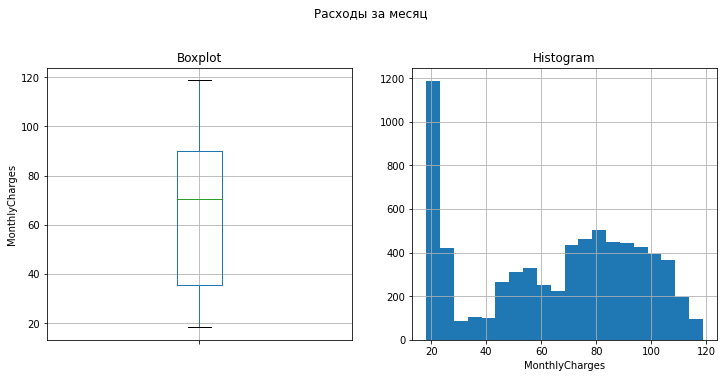

In [28]:
box_hist_plot(main_df, 'MonthlyCharges', 20, 'Расходы за месяц')

count    7043.000000
mean     2115.312885
std      2112.742814
min         0.000000
25%       436.750000
50%      1343.350000
75%      3236.690000
max      9221.380000
Name: TotalCharges, dtype: float64

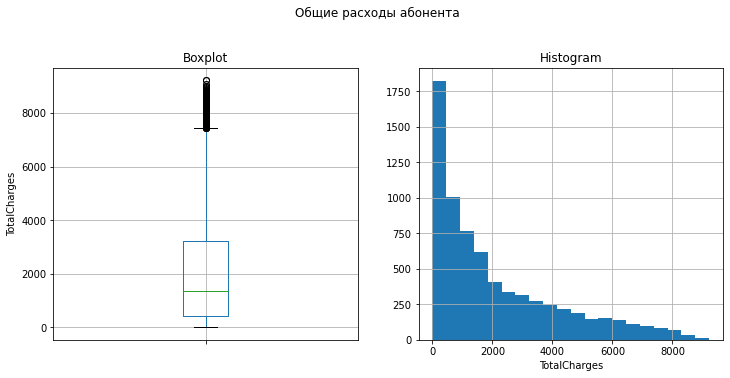

In [29]:
box_hist_plot(main_df, 'TotalCharges', 20, 'Общие расходы абонента')

count    7043.000000
mean      898.555729
std       683.130510
min         0.000000
25%       276.000000
50%       761.000000
75%      1461.000000
max      2314.000000
Name: DayDuration, dtype: float64

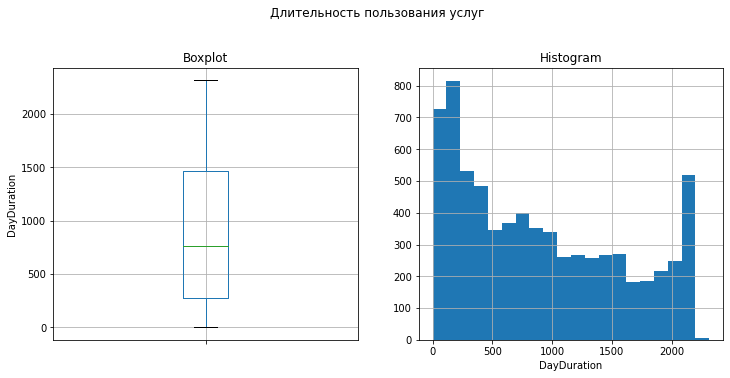

In [30]:
box_hist_plot(main_df, 'DayDuration', 20, 'Длительность пользования услуг')

###  Исследование категориальных признаков 

In [31]:
cat_cols = ['Type', 'PaperlessBilling', 'PaymentMethod', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
            'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 
            'StreamingMovies','MultipleLines']

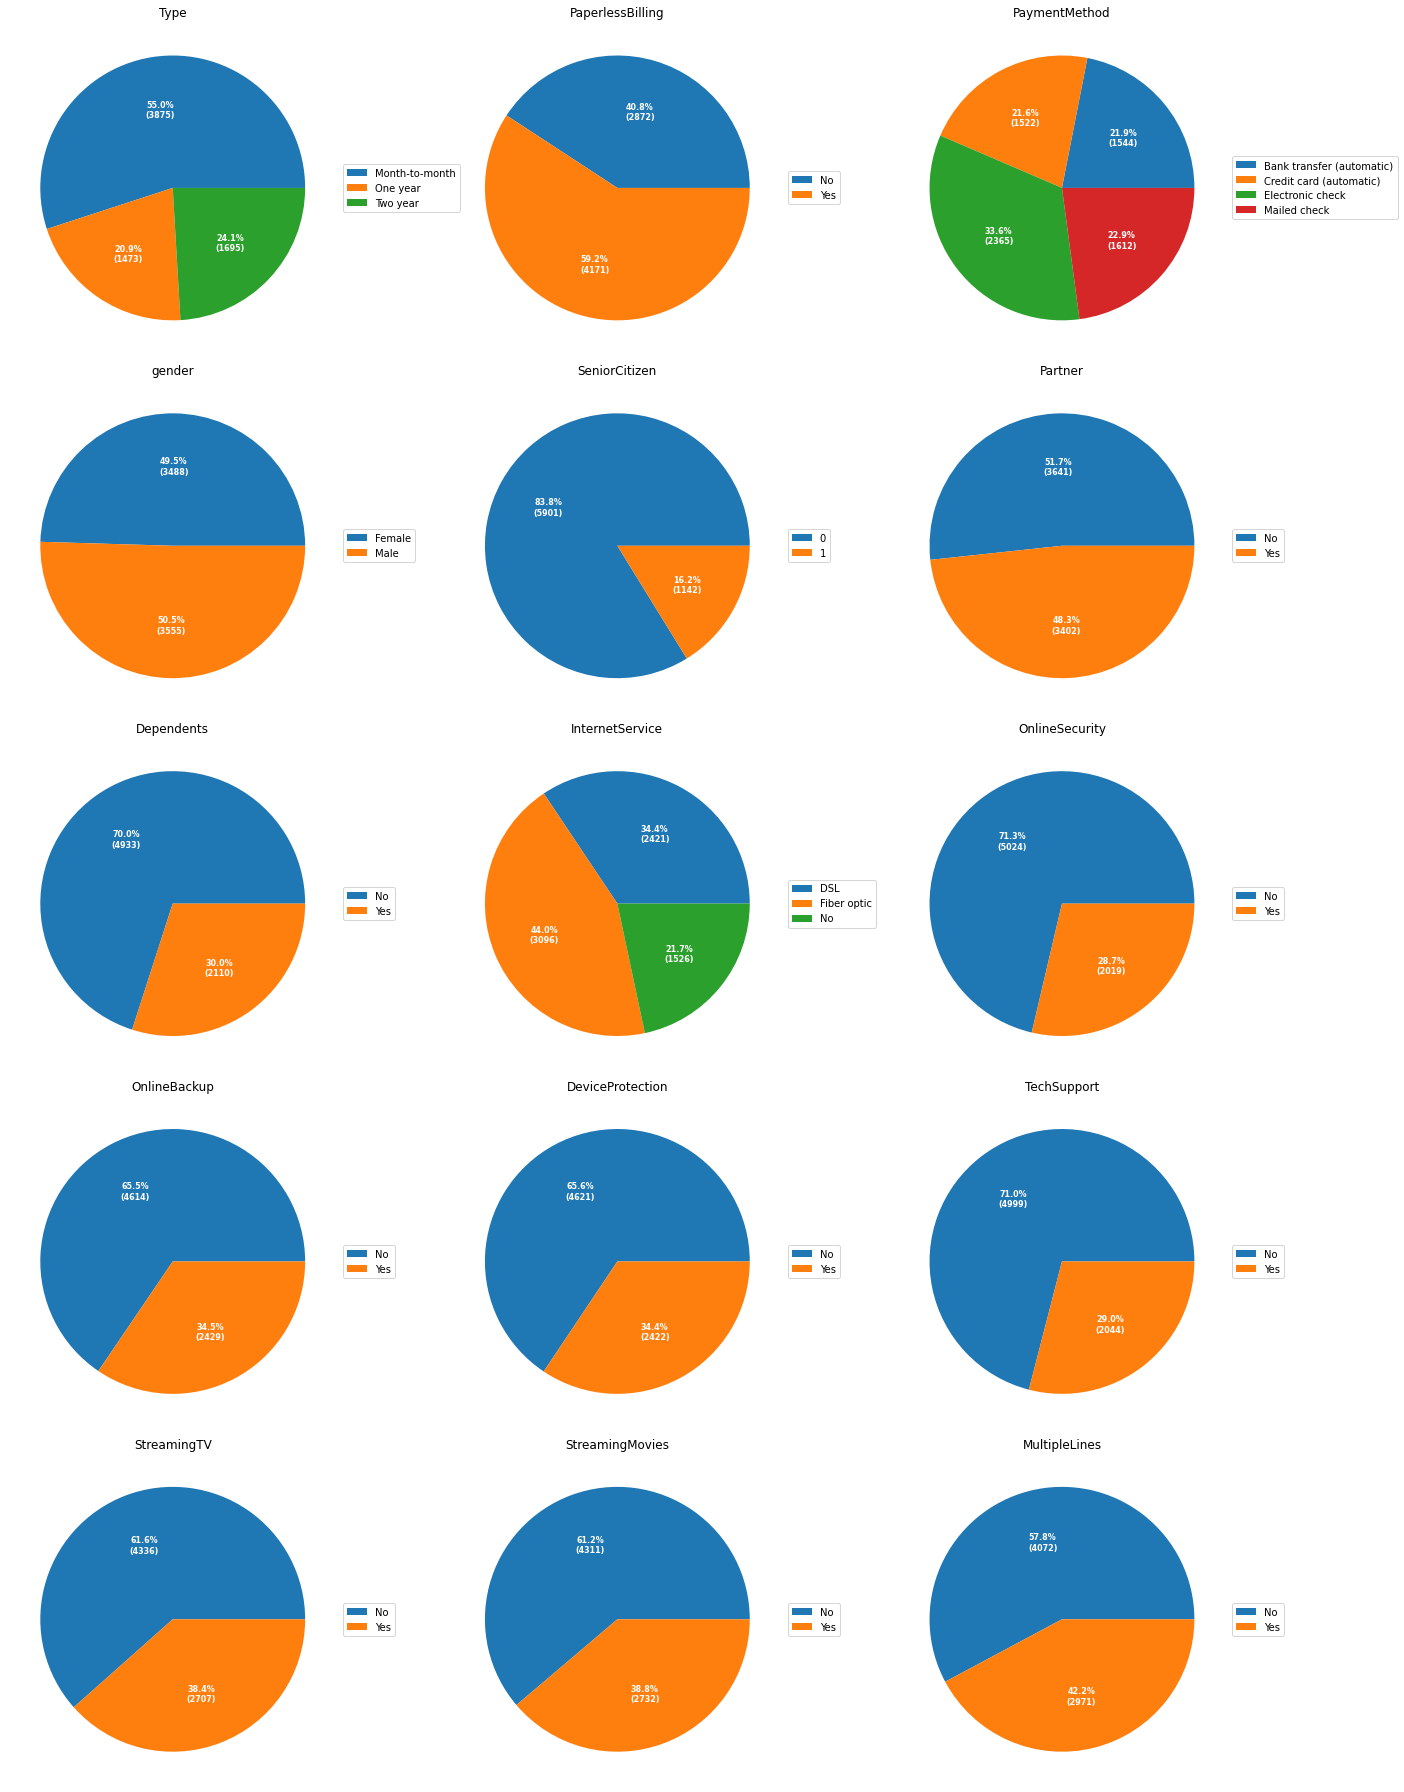

In [32]:
plot_pie_charts(main_df, cat_cols)

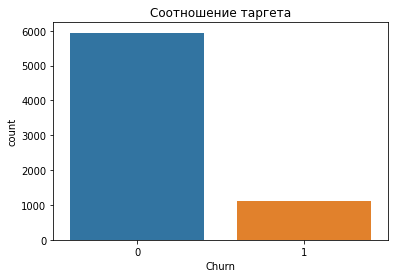

In [33]:
# Рассмторим как распределен наш таргет
sns.countplot(data=main_df, x="Churn")
plt.title('Соотношение таргета');

**Вывод:** В ходе исследования графиков распределения признаков было выяснено:

***Для числовых признаков:***

* Признак `MonthlyCharges` (расходы за месяц) не имеет выбросов. Распределение имеет бимодальный характер: первый (в тоже время наибольший) пик приходится на значение 20, 2-ой на значение 80.


* Признак `TotalCharges`(Общие расходы абонента) имеет выбросы. Распределение смещено влево. С учетом признака `MonthlyCharges` можно предположить, что большая часть клиентов оператора связи «ТелеДом» это пользователи "бюджетных" услуг.


* Признак `DayDuration`(Длительность пользования услуг) не имеет выбросов. Распределение имеет бимодальный характер: оба пика приходятся на начало и конец гистограммы. Можно предположить, что большая часть абонентов - это новоприбывшие и постоянные клиенты.

***Для категориальных признаков:***

Наибольшая часть абонентов:
* пользуется типом оплаты "Ежемесячно" (55%)
* НЕ пенсионеры (84%)
* НЕ имеют детей (70%)
* НЕ подключены к услуге блокировки опасных сайтов (71%)
* НЕ подключены к услуге выделенной линии технической поддержки (71%)

Большая часть абонентов:
* использует электронный расчетный лист вместо бумажного (59% против 41%)
* использует электронный чек (34%), все остальные способы оплат распределены примерно поровну
* подключены к интернету через оптоволокно (44%)
* НЕ подключены к услуге облачного хранилища файлов для резервного копирования данных (65%)
* НЕ подключены к услуге антивируса (66%)
* НЕ подключены к услуге стрмингового телевидения (66%)
* НЕ подключены к услуге "каталог фильмов" (61%)
* НЕ имеют подключение телефона к нескольким линиям одновременно (58%)

Одинаковое количество абонентов:
* по полам 
* наличию супруга/супруги

Для таргета заметен явный дисбаланс - при разбиении на выборки в дальнейшем, это необходимо учитывать.

### Корреляционный анализ

In [34]:
# Создадим список с названиями столбцов числовых (непрерывных) признаков
interval_cols = ['MonthlyCharges', 'TotalCharges', 'DayDuration']

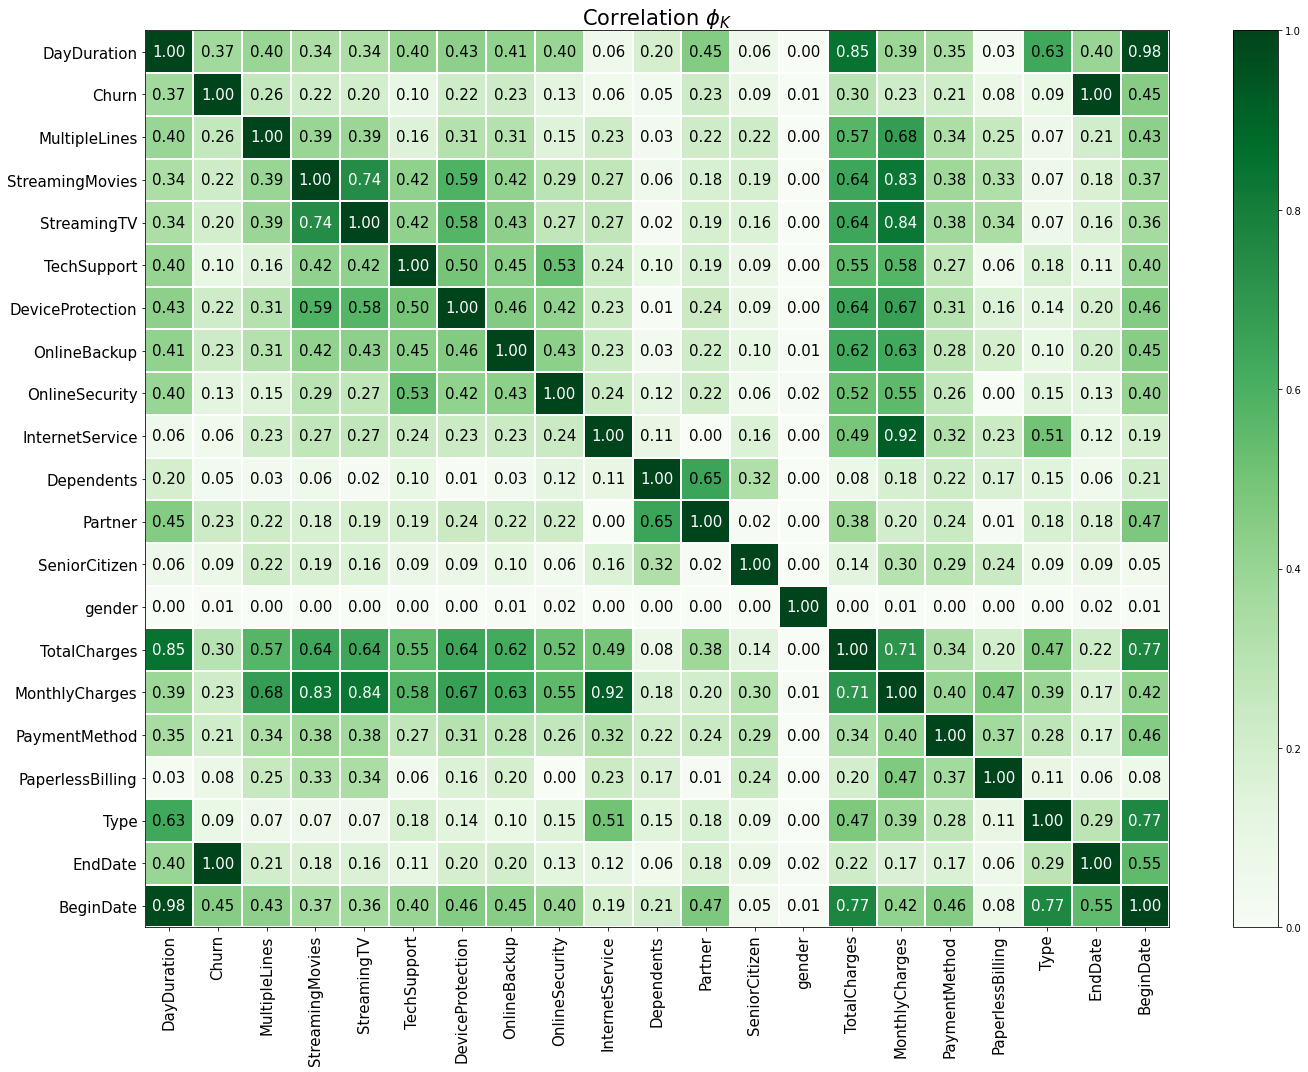

In [35]:
phik_overview = phik_matrix(main_df.drop('customerID', axis=1), interval_cols = interval_cols)

# Визуализация матрицы корреляции
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Greens', 
    title=r'Correlation $\phi_K$',
    fontsize_factor=1.5,
    figsize=(20, 15)
)

**Вывод:** Подтвержается то о чем мы говорили выше в разделе 2.2 при создании таргета: он на 100% коррелирует с признаком `EndDate`. Новый признак `DayDuration` мульколлинеарен признаку `BeginDate`. Таким образом, было бы лучше их убрать из нашего датасета перед обучением модели.

Также можно видеть, что признак `MonthlyCharges` мультиколлинеарен с признаком `InternetService` (за порог классификации считаем 0.9) и вообще довольно сильно коррелирует с остальными признаками. Его можно тоже убрать перед обучением.

Произведем графический анализ с группировкой по таргету:

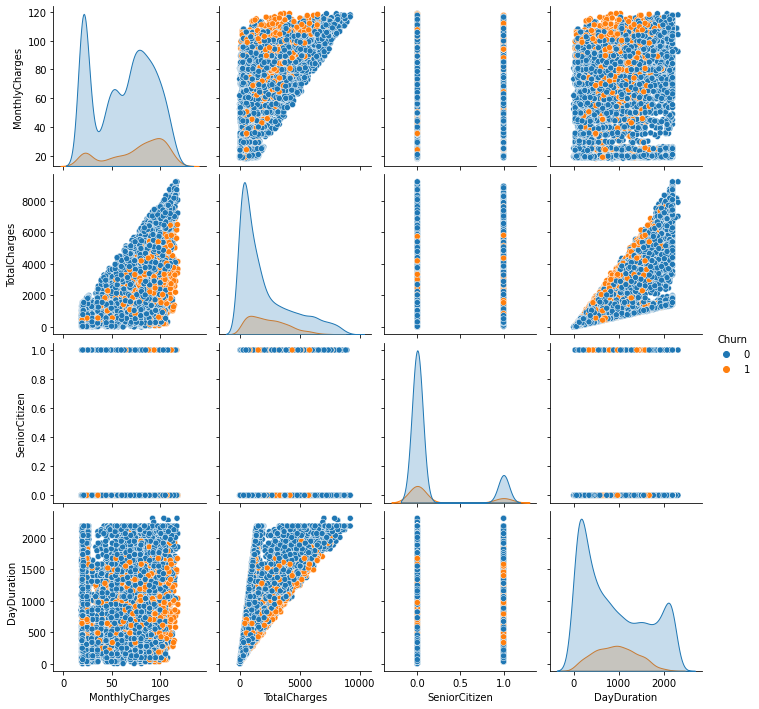

In [36]:
# Используем scatterplot matrix для анализа связи между таргетом и числовыми признаками
main_df_scatter = main_df[['MonthlyCharges', 'TotalCharges', 'SeniorCitizen', 'DayDuration', 'Churn']]
sns.pairplot(main_df_scatter, hue='Churn');

Из полученной матрицы рассеяния видно, что нет четкой границы между 2-мя категориями абонентов - каждый синий кружок (0) среди большего кол-ва оранжевых (1) и наоборот - свидетельство нестандартной комбинации признаков. Скорее всего линейные модели здесь покажут очень скромный результат.

## Машинное обучение 

### Подготовка данных к обучению

Уберем из датасета признаки `BeginDate`, `EndDate` и `MonthlyCharges`. Также переводим `CustomerID` в индекс датасета. 

In [37]:
main_df_init = main_df.set_index('customerID')
main_df_init = main_df_init.drop(['BeginDate', 'EndDate', 'MonthlyCharges'], axis=1)

In [38]:
main_df_init.head(5)

,Type,PaperlessBilling,PaymentMethod,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,Churn,DayDuration
customerID,,,,,,,,,,,,,,,,,,
7590-VHVEG,Month-to-month,Yes,Electronic check,31.04,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,No,0,31
5575-GNVDE,One year,No,Mailed check,2071.84,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No,0,1036
3668-QPYBK,Month-to-month,Yes,Mailed check,226.17,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No,0,123
7795-CFOCW,One year,No,Bank transfer (automatic),1960.60,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,No,0,1371
9237-HQITU,Month-to-month,Yes,Electronic check,353.50,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No,0,153


Столбцы успешно убраны.

In [39]:
# Определим колонки которые нужно масштабировать и закодировать
num_columns = ['TotalCharges', 'DayDuration']

categ_cols = ['Type', 'PaperlessBilling', 'PaymentMethod', 'gender', 'Partner', 'Dependents',
            'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 
            'StreamingMovies','MultipleLines', 'SeniorCitizen']

# Разбиение датасета на выборки (с учетом дисбаланса класса)
X = main_df_init.drop('Churn', axis=1)
y = main_df_init['Churn']

X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=TEST_SIZE, 
    random_state=RANDOM_STATE, 
    stratify=y
)

In [40]:
X.shape, y.shape

((7043, 17), (7043,))

In [41]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((5282, 17), (1761, 17), (5282,), (1761,))

Размеры полученных выборок выглядят адекватно.

Для обучения различных моделей лучше использовать соответвующие типы кодирования и масштабирования, либо вообще не использовать. Так например, деревья лучше работают с порядковым кодированием (*OrdinalEncoding*) и без масштабирования; с линейными моделями необходимо применять и масштабирование и прямое кодирование (*OneHotEncoding*).

In [42]:
# Создание объектов предобработки признаков 
ohe_encoder = OneHotEncoder(drop='first', sparse=False)
ord_encoder = OrdinalEncoder()
scaler = StandardScaler()

# Масштабирование количественных признаков тренировочной выборки
X_train_scaled = scaler.fit_transform(X_train[num_columns]) 
df_train_scaled = pd.DataFrame(X_train_scaled, columns=num_columns)

# Кодирование категориальных признаков с OneHotEncoder тренировочной выборки 
X_train_ohe = ohe_encoder.fit_transform(X_train[categ_cols])
ohe_encoder_col_names = ohe_encoder.get_feature_names()
df_train_ohe = pd.DataFrame(X_train_ohe, columns=ohe_encoder_col_names)

# Объединение масштабированных и закодированных признаков с OneHotEncoder (для линейных моделей)
X_train_scaled_ohe = pd.concat([df_train_scaled, df_train_ohe], axis=1)

# Кодирование категориальных признаков с OrdinalEncoder тренировочной выборки (для моделей деревьев)
X_train_ord = X_train.copy()
X_train_ord[categ_cols] = ord_encoder.fit_transform(X_train[categ_cols])

### Обучение и анализ моделей

Для классификации используем 4 модели:

*   *LogisticRegression* (Логистическая регрессия)
*   *DecisionTreeClassifier* (Дерево решений)
*   *LGBMClassifier* (Модель классификации градиентного бустинга)
*   *CatBoostClassifier* (Модель классификации градиентного бустинга от Яндекс)

Для подбора гиперпараметров будем использовать *OptunaSearchCV* в основе которой лежит байесовская оптимизация - данный метод позволяет быстрее находить лучшие значения гиперпараметров, чем случайный поиск (RandomizedSearchCV), и за меньшее количество итераций чем поиск по сетке (*GridSearchCV*).

In [43]:
# Создадим список для записи результатов моделей
models_dict = {}

In [44]:
# Определим функцию для подбора лучших гиперпараметров с помощью Optuna
def optuna_func(model, model_params, model_name, models_dict, X_train_set):
    oscv = OptunaSearchCV(
        model,
        model_params,
        cv=5,
        n_trials = 100,
        timeout = 600,
        scoring='roc_auc',
        random_state = RANDOM_STATE
    )
    
    oscv.fit(X_train_set, y_train)
    
    models_dict[model_name] = oscv.best_score_
    
    print('Лучшие гиперпараметры модели', oscv.best_params_)
    print('Метрика ROC-AUC на кросс-валидации', oscv.best_score_)
    
    return oscv

- **Логистическая регрессия**

In [45]:
model_LR = LogisticRegression(random_state=RANDOM_STATE, solver='liblinear', penalty='l1')

params_LR = {
      'C': distributions.IntDistribution(1, 100)
}

In [46]:
best_LR_model = optuna_func(model_LR, params_LR, 'LogisticRegression', models_dict, X_train_scaled_ohe)

Лучшие гиперпараметры модели {'C': 92}
Метрика ROC-AUC на кросс-валидации 0.7715403146785859


Для логрег метрика ROC-AUC на кросс-валидации составила 0.77, алгоритм OptunaSearchCV уменьшал регуляризацию, но требуемый порог (0.85) не был достигнут.

- **Дерево решений**

In [47]:
model_TC = DecisionTreeClassifier(random_state=RANDOM_STATE)
params_TC = {
    'min_samples_split': distributions.IntDistribution(2,15),
    'min_samples_leaf': distributions.IntDistribution(1,50),
    'max_depth': distributions.IntDistribution(2,50)
}

In [48]:
best_TC_model = optuna_func(model_TC, params_TC, 'DecisionTreeClassifier', models_dict, X_train_ord)

Лучшие гиперпараметры модели {'min_samples_split': 3, 'min_samples_leaf': 38, 'max_depth': 6}
Метрика ROC-AUC на кросс-валидации 0.7964115854998506


Для дерева классификации метрика ROC-AUC на кросс-валидации составила 0.79, алгоритм OptunaSearchCV определил лучшими такие значения гиперпараметров:

* *min_samples_split* = 3 (число объектов в узле, для разделения их на классы), 
* *min_samples_leaf* = 38 (число объектов в одном листе)
* *max_depth* = 6 (число уровней или максимальная глубина дерева)

Значение метрики выше чем у логрег, но требуемый порог еще не достигнут.

- **LGBMClassifier**

In [49]:
model_LGBM = LGBMClassifier(random_state=RANDOM_STATE)

params_LGBM = {
    'num_leaves': distributions.IntDistribution(100, 500),
    'n_estimators': distributions.IntDistribution(50, 200),
    'learning_rate': distributions.FloatDistribution(0.005, 0.2),
    'max_depth': distributions.IntDistribution(1, 50) 
}

In [50]:
best_LGBM_model = optuna_func(model_LGBM, params_LGBM, 'LGBMClassifier', models_dict, X_train_ord)

Лучшие гиперпараметры модели {'num_leaves': 100, 'n_estimators': 195, 'learning_rate': 0.19077005850130746, 'max_depth': 3}
Метрика ROC-AUC на кросс-валидации 0.8944088132006922


Для градиентного бустинга метрика ROC-AUC на кросс-валидации составила 0.89, алгоритм OptunaSearchCV определил лучшими такие значения гиперпараметров:

* *num_leaves* = 100 (максимальное число листьев в одном дереве) 
* *n_estimators* = 195 (число итераций в ансамбле)
* *learning_rate* = 0.19077005850130746 (скорость обучения)
* *max_depth* = 3 (максимальная глубина дерева)

Значение метрики выше чем у всех предыдущих моделей. Требуемый порог достигнут с запасом.

- **CatBoostClassifier**

In [51]:
model_CatBoost = CatBoostClassifier(random_state=RANDOM_STATE, verbose=False)

params_CatBoost = {
    'n_estimators': distributions.IntDistribution(50, 200),
    'learning_rate': distributions.FloatDistribution(0.01, 0.2),
    'depth': distributions.IntDistribution(1, 10)
}

In [52]:
best_CatBoost_model = optuna_func(model_CatBoost, params_CatBoost, 'CatBoostClassifier', models_dict, X_train_ord)

Лучшие гиперпараметры модели {'n_estimators': 200, 'learning_rate': 0.19435039272086627, 'depth': 4}
Метрика ROC-AUC на кросс-валидации 0.91006076800243


Для градиентного бустинга CatBoost метрика ROC-AUC на кросс-валидации составила 0.91, алгоритм OptunaSearchCV определил лучшими такие значения гиперпараметров:

* *n_estimators* = 200 (число итераций в ансамбле)
* *learning_rate* = 0.19435039272086627 (скорость обучения)
* *depth* = 4 (глубина дерева)

Значение метрики выше чем у всех предыдущих моделей. Требуемый порог достигнут с еще большим запасом.

Сведем все данные в таблицу для сравнения:

In [53]:
models_df = pd.DataFrame.from_dict(models_dict, orient='index', columns=['Значение ROC-AUC'])

models_df.reset_index(inplace=True)
models_df.columns = ['Модель', 'Значение ROC-AUC']

In [54]:
models_df.sort_values(by='Значение ROC-AUC', ascending=False)

,Модель,Значение ROC-AUC
3,CatBoostClassifier,0.910061
2,LGBMClassifier,0.894409
1,DecisionTreeClassifier,0.796412
0,LogisticRegression,0.771540


**Выводы:** Наилучшими оказались модели градиентного бустинга. Причем только им удалось перешагнуть порог в 0.85 по метрике ROC-AUC. Самой лучшей оказалась модель CatBoost - ее мы и проверим далее на тестовой выборке.

### Проверка лучшей модели на тестовой выборке

In [55]:
# Предварительно закодируем тестовую выборку
X_test_ord = X_test.copy()
X_test_ord[categ_cols] = ord_encoder.transform(X_test[categ_cols])

In [56]:
probs_y_test = best_CatBoost_model.predict_proba(X_test_ord)[:, 1]
print(f'Значение метрики ROC-AUC на тестовой выборке: {roc_auc_score(y_test, probs_y_test)}')

Значение метрики ROC-AUC на тестовой выборке: 0.9282833720787961


Значение ROC-AUC выбранной модели на тестовой выборке оказалось выше требуемого (0.85). Требуемый результат достигнут.

### Исследование модели

Произведем анализ важности признаков с *feature_importances_*, чтобы узнать какие признаки для модели оказались более или менее важными.

In [57]:
feature_importances = pd.DataFrame(
    {
        'Feature': X_train_ord.columns,
        'Importance': best_CatBoost_model.best_estimator_.feature_importances_
    }).sort_values('Importance', ascending=False)

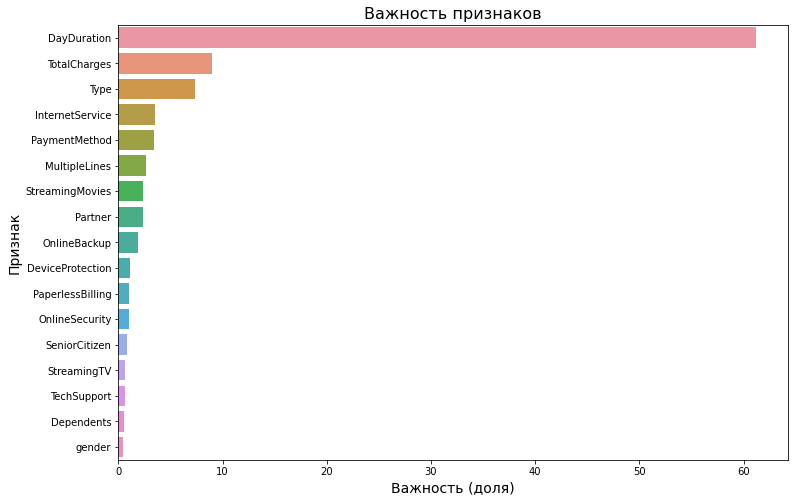

In [58]:
# Определим таблицу
df_impr = feature_importances

plt.figure(figsize=(12, 8))

# Построим столбчатый график для наглядности
ax = sns.barplot(data=feature_importances, x="Importance", y="Feature")

ax.set_title('Важность признаков', fontsize=16)
ax.set_xlabel('Важность (доля)', fontsize=14)
ax.set_ylabel('Признак', fontsize=14)

plt.show()

Еще раз исследуем вклад признаков в предсказания модели, но уже с помощью SHAP-значений:

In [59]:
explainer = shap.TreeExplainer(best_CatBoost_model.best_estimator_)

In [60]:
shap_values = explainer(X_train_ord)

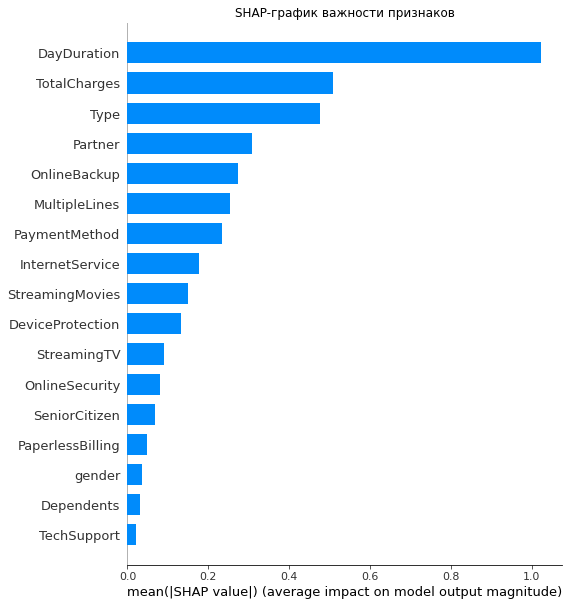

In [61]:
shap.summary_plot(shap_values, X_train_ord, plot_type="bar", show=False)

plt.title("SHAP-график важности признаков")
plt.show()

Из SHAP-графика выше видно, что 3-ка главных признаков такая же как и в графике полученного с помощью *feature_importances_*, однако имеются и различия: так согласно SHAP-графику признаки `Partner` и `OnlineBackup` для модели оказались важнее чем `InternetService` и `PaymentMethod` соответственно.

Тепер посмотрим, как признаки влияют на каждое предсказание модели:

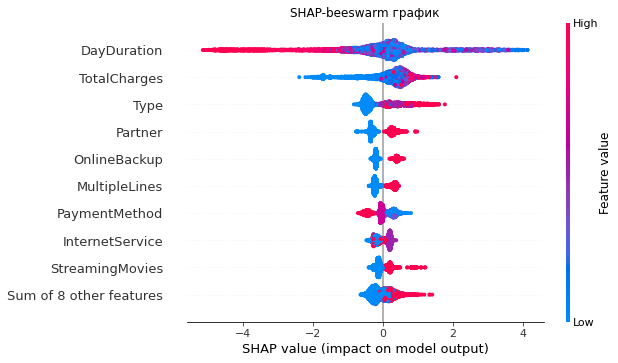

In [62]:
shap.plots.beeswarm(shap_values, show=False)

fig, ax = plt.gcf(), plt.gca()
ax.set_title('SHAP-beeswarm график')

plt.show()

Из графика SHAP-beeswarm видно, что чем больше значение признака `DayDuration` тем меньше SHAP-значения объектов - если у наблюдения высокие значения этого признака, то у него высокая вероятность принадлежности к классу 0 или то, что клиент останется. Также, чем больше значения признаков `TotalCharges` и `Type`, тем больше SHAP-значения объектов - если у наблюдения высокие значения этих признаков, то у него высокая вероятность принадлежности к классу 1 или то, что абонент может отказатся от услуг компании. 

Дополнительно можем посмотреть матрицу ошибок. Как мы помним в исходном датасете наблюдается дисбаланс классов в сторону оставшихся клиентов. Посмотрим как наша модель справляется с классификацией абонентов:

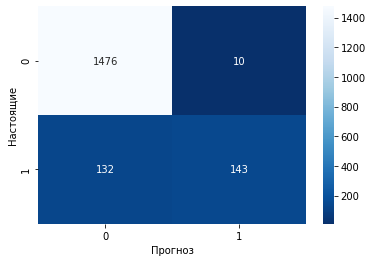

In [63]:
CBC_predicts = best_CatBoost_model.predict(X_test_ord)

cm = confusion_matrix(y_test, CBC_predicts)
sns.heatmap(cm, annot=True, cmap='Blues_r', fmt='g')
plt.xlabel('Прогноз')
plt.ylabel('Настоящие');

Видно, что наша модель отлично улавливает остающихся клиентов, но в половине случаев ошибается с уходящими абонентами.

## Выводы

Для телекоммуникационной компании «ТелеДом» с целью удержания клиентов на основании имеющихся групп данных (персональные данные клиентов и информацию об их тарифах и услугах) было необходимо разработать модель, позволяющую предсказывать их уход.

Итоговая работа была разделена на несколько этапов:
1. Первичный осмотр групп данных и объединение их в единый датасет
2. Предобработка данных с целью устранения пропусков, возникших после объединиения исходных таблиц
3. Исследовательский анализ числовых и категориальных признаков, а также корреляционный анализ
4. Обучение моделей и анализ наилучшей с использованием метрики ROC-AUC 

Все этапы были выполнены.

Для обучения моделей и итогового тестирования были использованы следующие признаки:
* `Type` - тип оплаты услуг
* `PaperlessBilling` - используется ли электронный расчётный лист 
* `PaymentMethod` - тип платежа
* `TotalCharges` - общие расходы абонента
* `gender` - пол
* `SeniorCitizen` - является ли абонент пенсионером
* `Partner` - есть ли у абонента супруг или супруга
* `Dependents` - есть ли у абонента дети
* `InternetService` - тип подключения 
* `OnlineSecurity` - блокировка опасных сайтов
* `OnlineBackup` - облачное хранилище файлов для резервного копирования данных
* `DeviceProtection` - антивирус
* `TechSupport` - выделенная линия технической поддержки
* `StreamingTV` - стриминговое телевидение
* `StreamingMovies` - каталог фильмов
* `MultipleLines` - подключение телефона к нескольким линиям одновременно
* `DayDuration` - длительность пользования клиентом услугами компании (в днях), вычислена на основе признаков BeginDate и EndDate

Для решения задачи классификации были опробованы различные модели: линейные, деревья и бустинги. Для каждой модели были произведены соответвующие предобработки: масштабирование и прямое кодирование (OneHotEncoding) для линейных, только порядковое кодирование (OrdinalEncoding) для моделей деревьев.

По итогу наилучшими моделями оказались модели бустинга - LGBMClassifier (ROC-AUC на кросс-валидации = 0,89) и CatBoostClassifier (ROC-AUC на кросс-валидации 0.91). Для дальнейшей работы была выбрана последняя с гиперпараметрами:
* *n_estimators* = 200 (число итераций в ансамбле)
* *learning_rate* = 0.19435039272086627 (скорость обучения)
* *depth* = 4 (глубина дерева)

На тестовой выборке модель показала удовлетворительный результат - 0.92 по метрике ROC-AUC.

В конце работы был произведен анализ итоговой модели: было выяснено, что для модели наиважнейшими признакми оказались:
* DayDuration
* TotalCharges

Предположительно, что постоянные клиенты с меньшими общими расходами уходят с меньшей вероятностью.

Дополнительно, была исследована матрица ошибок - наша модель хорошо определяет клиентов которые продолжат пользоваться услугами компании, но в половине случаев ошибается с теми кто вероятно уйдет.

Для компании «ТелеДом» можно посоветовать следующее:
1. Более отвественно и внимательно подойти к этапу сбора данных - некоторые в исследуемом датасете имели пропуски и неверные типы данных

2. Проработать требования к самому ТЗ: что для заказчика важнее - упущенная выгода от ушедших клиентов или сохранение бюджета на акциях и промокодах.